In [117]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare, stats, norm, linregress
from statsmodels.sandbox.stats.runs import runstest_1samp
from itertools import combinations, product
import math

In [2]:
# Load CSV
df = pd.read_csv('hit5_clean_deduped.csv')

In [3]:
number_columns = ['Num1', 'Num2', 'Num3', 'Num4', 'Num5']
all_numbers = pd.concat([df[col] for col in number_columns], ignore_index=True)


In [109]:
frequency = all_numbers.value_counts().sort_index()
frequency_df = frequency.reset_index().rename(columns={'index': 'Number', 0: 'Frequency'})
frequency_df = frequency_df.sort_values(by='count', ascending=False)
print(frequency_df.to_string(index=False))


 Number  count
     38     30
     12     30
     32     26
     30     26
     11     25
     28     25
      3     25
     29     24
     14     24
     35     24
     40     23
     18     23
     23     23
     27     23
     21     23
     24     22
     19     22
     22     22
     34     22
     10     22
      9     22
     41     22
      4     22
     36     22
     39     21
      1     21
     17     21
     13     21
      5     21
     25     19
     31     19
      8     19
      7     19
     16     18
      6     18
     26     17
     20     17
     33     17
     15     17
     37     17
      2     14
     42     12


In [36]:

draws = df[number_columns].values

In [18]:
# Hot/cold:
all_numbers = pd.Series(draws.flatten())
frequency = all_numbers.value_counts().sort_index()
mean_freq = frequency.mean()
std_freq = frequency.std()
hot = frequency[frequency > mean_freq + std_freq]
cold = frequency[frequency < mean_freq - std_freq]
print("Hot numbers (more frequent):", hot.to_dict())
print("Cold numbers (less frequent):", cold.to_dict())

Hot numbers (more frequent): {12: 30, 30: 26, 32: 26, 38: 30}
Cold numbers (less frequent): {2: 14, 15: 17, 20: 17, 26: 17, 33: 17, 37: 17, 42: 12}


In [111]:
summary = {
    'Total draws': len(df),                         # Number of draw rows
    'Total numbers': all_numbers.count(),           # Total numbers drawn (draws x 5)
    'Mean': all_numbers.mean(),                     # Average drawn number
    'Median': all_numbers.median(),                 # Middle value (after sorting)
    'Standard Deviation': all_numbers.std(),        # Spread of data
    'Minimum': all_numbers.min(),                   # Smallest drawn number
    'Maximum': all_numbers.max(),                   # Largest drawn number
    '25% Quantile': all_numbers.quantile(0.25),     # Lower quartile
    '75% Quantile': all_numbers.quantile(0.75),     # Upper quartile
    'Mode': all_numbers.mode().tolist()             # Most common drawn number(s)
}

print(f"Total Draws: {summary['Total draws']}")
print(f"Total numbers: {summary['Total numbers']}")
print(f"Mean: {summary['Mean']}")
print(f"Median: {summary['Median']}")
print(f"Standard Deviation: {summary['Standard Deviation']}")
print(f"Minimum: {summary['Minimum']}")
print(f"Maximum: {summary['Maximum']}")
print(f"25% Quantile': {summary['25% Quantile']}")
print(f"75% Quantile': {summary['75% Quantile']}")
print(f"Mode: {summary['Mode']}")

Total Draws: 180
Total numbers: 900
Mean: 21.62
Median: 22.0
Standard Deviation: 11.966770826102142
Minimum: 1
Maximum: 42
25% Quantile': 11.0
75% Quantile': 32.0
Mode: [12, 38]


In [19]:
# Consecutive Numbers
consecutive_draws = [(np.diff(np.sort(row)) == 1).sum() for row in draws]
total_with_consecutive = sum(x > 0 for x in consecutive_draws)
max_consecutive = max(consecutive_draws)
percent_with_consecutive = 100 * total_with_consecutive / len(draws)
print(f"Draws with at least one pair of consecutive numbers: {total_with_consecutive}")
print(f"Max pairs of consecutive numbers in any draw: {max_consecutive}")
print(f"Percent of draws with at least one consecutive pair: {percent_with_consecutive:.1f}%")

Draws with at least one pair of consecutive numbers: 73
Max pairs of consecutive numbers in any draw: 2
Percent of draws with at least one consecutive pair: 40.6%


In [22]:
# Temporal pattern: diff between same positions
diff_matrix = np.diff(draws, axis=0)
mean_diff = diff_matrix.mean()
std_diff = diff_matrix.std()
print(f"Mean gap/difference between same column in sequential draws: {mean_diff:.2f}")
print(f"Standard deviation of difference: {std_diff:.2f}")

Mean gap/difference between same column in sequential draws: -0.02
Standard deviation of difference: 9.43


,Number,Empirical Probability,Theoretical Probability
0,1,0.023333,0.02381
1,2,0.015556,0.02381
2,3,0.027778,0.02381
3,4,0.024444,0.02381
4,5,0.023333,0.02381
5,6,0.020000,0.02381
6,7,0.021111,0.02381
7,8,0.021111,0.02381
8,9,0.024444,0.02381
9,10,0.024444,0.02381


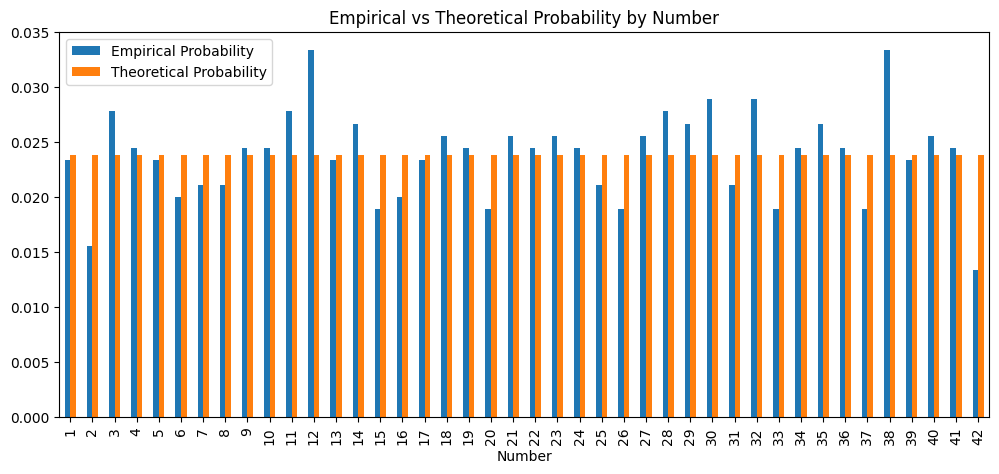

In [38]:
all_possible_numbers = range(1, 43)
all_numbers = pd.concat([df[col] for col in number_columns], ignore_index=True)
empirical_probs = all_numbers.value_counts(normalize=True).reindex(all_possible_numbers, fill_value=0)
theoretical_prob = 1/42  # For 42 possible numbers
prob_df = pd.DataFrame({
    "Number": all_possible_numbers,
    "Empirical Probability": empirical_probs.values,
    "Theoretical Probability": theoretical_prob
})
display(prob_df.head(10))

# plot all probabilities
prob_df.plot(x="Number", y=["Empirical Probability", "Theoretical Probability"], kind="bar", figsize=(12,5))
plt.title("Empirical vs Theoretical Probability by Number")
plt.show()


In [40]:
# ChiSquare


In [41]:
# Count occurrences for each possible number (1-42)
observed = all_numbers.value_counts().reindex(range(1, 43), fill_value=0).values

# Expected frequency (if all equally likely)
expected = [all_numbers.count() / 42] * 42

# Chi-Square test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_val:.4f}")

# Interpret result:
if p_val < 0.05:
    print("Statistically significant deviation from uniform distribution: Reject H0.")
else:
    print("No significant deviation: Cannot reject H0, distribution may be random/uniform.")

Chi-square statistic: 25.77
p-value: 0.9696
No significant deviation: Cannot reject H0, distribution may be random/uniform.


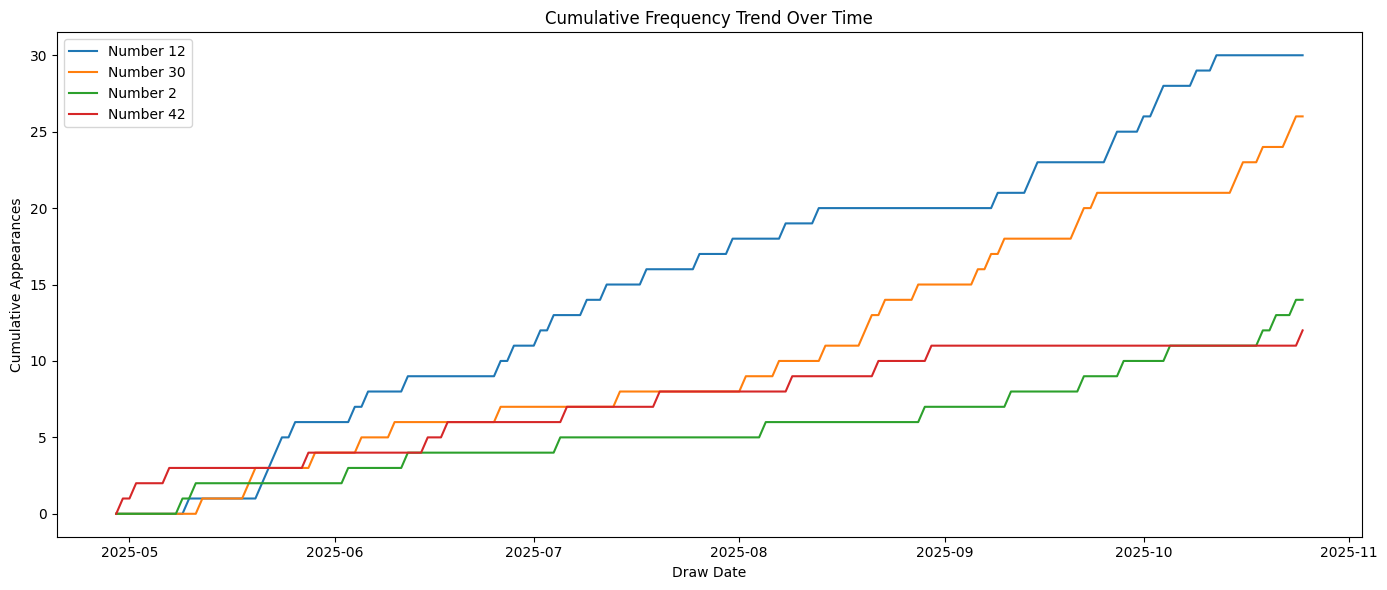

In [46]:
df['Date'] = pd.to_datetime(df['Date'])
df_date = df.sort_values('Date')


# Melt data to long format: each row = [date, number]
long_df = df_date.melt(id_vars=['Date'], value_vars=number_columns, var_name='Position', value_name='Number')

# Select sample numbers (top hot/cold or your favorites)
numbers_to_plot = [12, 30, 2, 42]  # Example; pick hot/cold or any

plt.figure(figsize=(14, 6))
for n in numbers_to_plot:
    long_df[f'hit_{n}'] = (long_df['Number'] == n).astype(int)
    # Calculate cumulative count over time for number n
    trend = long_df.groupby('Date')[f'hit_{n}'].sum().cumsum()
    plt.plot(trend, label=f'Number {n}')

plt.xlabel('Draw Date')
plt.ylabel('Cumulative Appearances')
plt.title('Cumulative Frequency Trend Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Per-Position Frequency Trend Analysis
# Plot how frequently a given number appears in each position (Num1...Num5) over time.


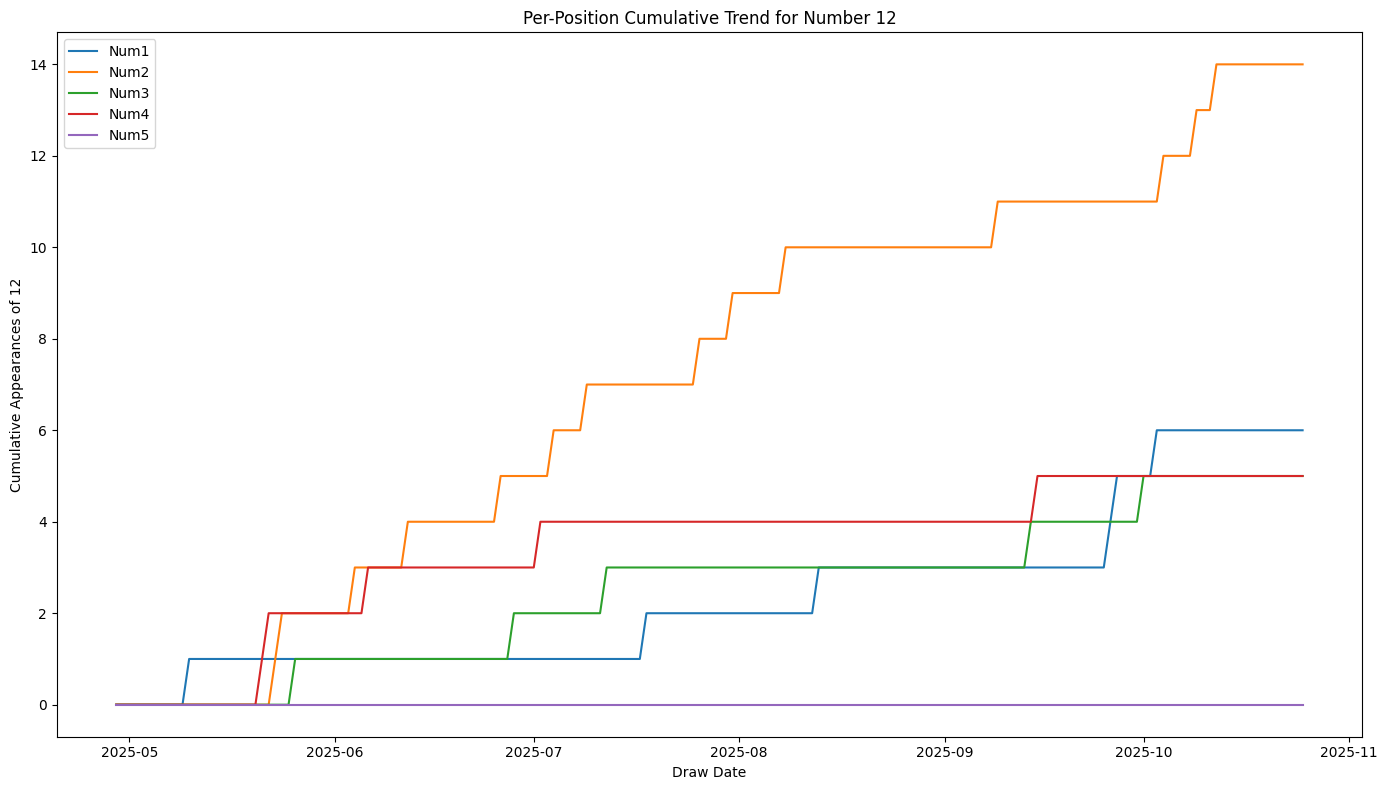

In [47]:


positions = ['Num1', 'Num2', 'Num3', 'Num4', 'Num5']
number_to_analyze = 12  # Example (change to any number you want)

plt.figure(figsize=(14, 8))

for pos in positions:
    # Binary column: did number_to_analyze appear at this position for each draw?
    col_indicator = (df_date[pos] == number_to_analyze).astype(int)
    trend = col_indicator.cumsum()
    plt.plot(df_date['Date'], trend, label=pos)

plt.xlabel('Draw Date')
plt.ylabel(f'Cumulative Appearances of {number_to_analyze}')
plt.title(f'Per-Position Cumulative Trend for Number {number_to_analyze}')
plt.legend()
plt.tight_layout()
plt.show()


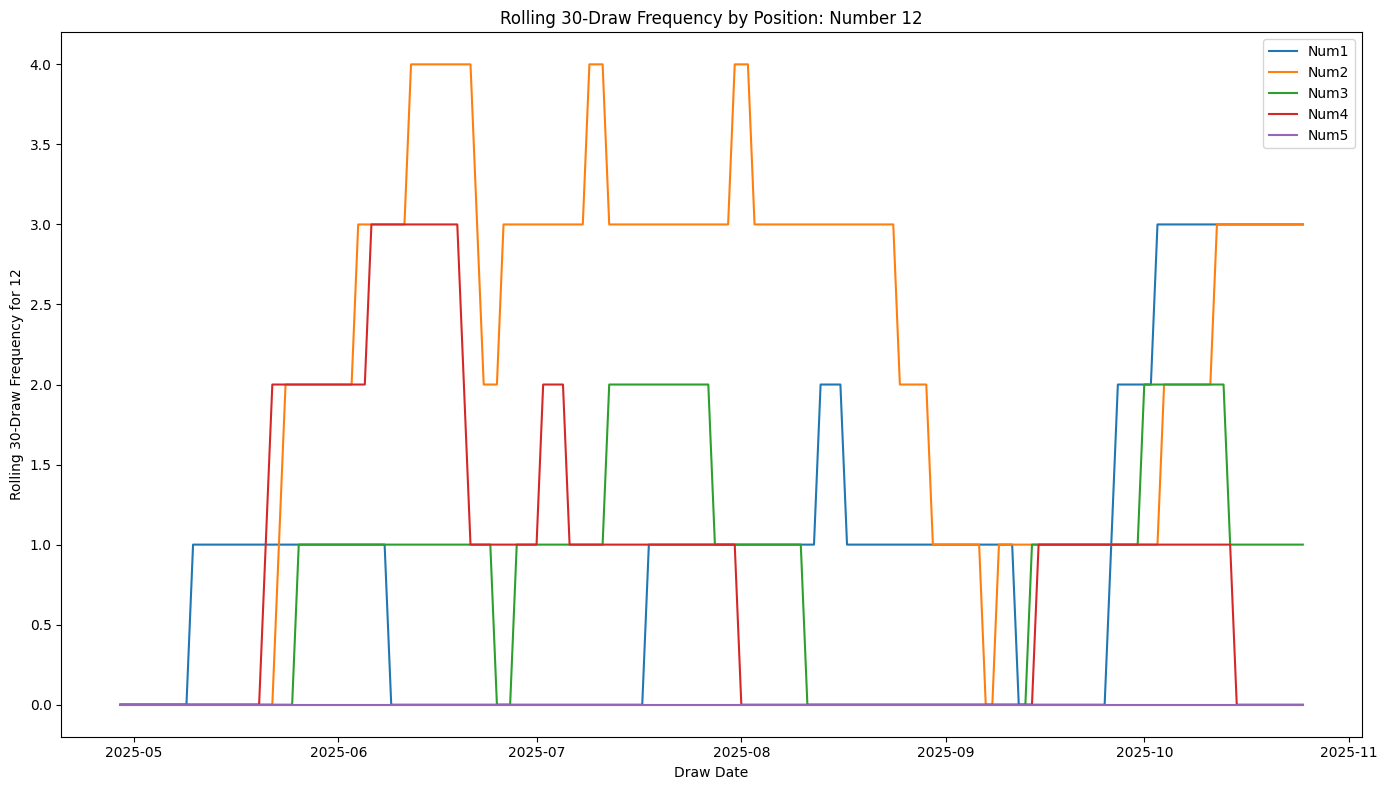

In [48]:
# 30 day window


window = 30  # rolling window size
positions = ['Num1', 'Num2', 'Num3', 'Num4', 'Num5']
number_to_analyze = 12  # Example: change to any number

plt.figure(figsize=(14,8))
for pos in positions:
    indicator = (df_date[pos] == number_to_analyze).astype(int)
    rolling_freq = indicator.rolling(window=window, min_periods=1).sum()
    plt.plot(df['Date'], rolling_freq, label=pos)

plt.xlabel('Draw Date')
plt.ylabel(f'Rolling {window}-Draw Frequency for {number_to_analyze}')
plt.title(f'Rolling {window}-Draw Frequency by Position: Number {number_to_analyze}')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:

# Randomness
# Example: Use median to convert numbers to 0/1 (above/below median)

median = all_numbers.median()
binary_seq = (all_numbers > median).astype(int)
z_stat, p_val = runstest_1samp(binary_seq, correction=True)
print(f"Runs test z-statistic: {z_stat:.2f}")
print(f"p-value: {p_val:.4f}")
if p_val < 0.05:
    print('Sequence shows non-randomness (reject H0).')
else:
    print('Sequence order appears random (cannot reject H0).')


Runs test z-statistic: -15.92
p-value: 0.0000
Sequence shows non-randomness (reject H0).


In [54]:
# Calculate lag-1 serial correlation for all numbers
# corr = all_numbers.autocorr(lag=1)
# print(f"Lag-1 serial correlation: {corr:.3f}")

# # (Optional): Test significance

# n = len(all_numbers.dropna())
# z = corr * np.sqrt((n-2) / (1 - corr**2))
# p_value = 2 * (1 - norm.cdf(abs(z)))
# print(f"z-score: {z:.2f}, p-value: {p_value:.4f}")
# if p_value < 0.05:
#     print('Serial correlation detected (reject H0 of independence).')
# else:
#     print('No serial correlation detected (sequence is independent).')


Lag-1 serial correlation: 0.687
z-score: 28.35, p-value: 0.0000
Serial correlation detected (reject H0 of independence).


In [55]:
df = pd.read_csv('hit5_clean_deduped.csv')
positions = ['Num1', 'Num2', 'Num3', 'Num4', 'Num5']

print("Lag-1 Serial Correlation by Position:")
for pos in positions:
    seq = df[pos].dropna()
    corr = seq.autocorr(lag=1)
    # Test for significance
    n = len(seq)
    if abs(corr) < 1:  # avoid divide by zero
        z = corr * np.sqrt((n-2) / (1 - corr**2))
        p_value = 2 * (1 - norm.cdf(abs(z)))
    else:
        z, p_value = np.nan, np.nan
    print(f"{pos}: r={corr:.3f}, z-score={z:.2f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print(f"  Significant correlation detected in {pos}. (Reject H0 of independence)")
    else:
        print(f"  No significant correlation in {pos}. (Cannot reject H0, sequence appears independent)")

Lag-1 Serial Correlation by Position:
Num1: r=-0.172, z-score=-2.33, p-value=0.0199
  Significant correlation detected in Num1. (Reject H0 of independence)
Num2: r=-0.053, z-score=-0.71, p-value=0.4782
  No significant correlation in Num2. (Cannot reject H0, sequence appears independent)
Num3: r=-0.017, z-score=-0.23, p-value=0.8179
  No significant correlation in Num3. (Cannot reject H0, sequence appears independent)
Num4: r=0.007, z-score=0.10, p-value=0.9213
  No significant correlation in Num4. (Cannot reject H0, sequence appears independent)
Num5: r=-0.119, z-score=-1.60, p-value=0.1101
  No significant correlation in Num5. (Cannot reject H0, sequence appears independent)


In [56]:
# gaps between wins

In [58]:

all_possible_numbers = range(1, 43)
longest_gap = {}

# For each number, determine the largest interval between appearances
for num in all_possible_numbers:
    # Locate every row where num appears
    hits = df[number_columns].apply(lambda row: num in row.values, axis=1)
    hit_indices = np.where(hits)[0]
    if len(hit_indices) > 0:
        # Calculate gaps between each occurrence
        gaps = np.diff(hit_indices)
        max_gap = gaps.max() if len(gaps) > 0 else len(df) - 1
        # Consider from last hit to end
        last_gap = len(df) - 1 - hit_indices[-1]
        # Consider from start to first hit
        first_gap = hit_indices[0]
        overall_max = max(max_gap, last_gap, first_gap)
    else:
        overall_max = len(df)  # never appeared
    longest_gap[num] = overall_max

# Convert to DataFrame and (optional) save to CSV
longest_gap_df = pd.DataFrame(list(longest_gap.items()), columns=['Number', 'Longest Gap'])
longest_gap_df = longest_gap_df.sort_values('Longest Gap', ascending=False)
longest_gap_df.to_csv('hit5_longest_gaps.csv', index=False)

# Display top 15
print(longest_gap_df.head(15).to_string(index=False))


 Number  Longest Gap
     31           58
     42           56
     15           45
     25           41
     20           39
     33           37
     24           35
      7           35
     23           32
      5           32
     38           32
      2           31
     40           31
     39           31
     16           30


In [59]:
# Average gap intervals

In [61]:
gap_dict = {}

for num in all_possible_numbers:
    hits = df[number_columns].apply(lambda row: num in row.values, axis=1)
    hit_indices = np.where(hits)[0]
    if len(hit_indices) > 1:
        gaps = np.diff(hit_indices)
        avg_gap = gaps.mean() if len(gaps) > 0 else np.nan
        gap_dict[num] = avg_gap
    else:
        gap_dict[num] = np.nan  # Not enough data for gap calculation

average_gap_df = pd.DataFrame(list(gap_dict.items()), columns=['Number', 'Average Gap'])
print(average_gap_df.to_string(index=False))

# Overall average of gaps for all numbers:
overall_avg_gap = average_gap_df['Average Gap'].mean()
print(f'Overall average gap for all numbers: {overall_avg_gap:.2f}')

 Number  Average Gap
      1     8.050000
      2    12.923077
      3     6.625000
      4     7.761905
      5     8.300000
      6    10.176471
      7     9.666667
      8     8.666667
      9     7.095238
     10     7.714286
     11     7.041667
     12     5.344828
     13     8.150000
     14     7.739130
     15     9.875000
     16     9.764706
     17     8.450000
     18     7.454545
     19     8.333333
     20     9.437500
     21     7.818182
     22     7.761905
     23     7.090909
     24     7.571429
     25     9.166667
     26     8.437500
     27     7.545455
     28     7.000000
     29     6.521739
     30     6.600000
     31     9.944444
     32     6.200000
     33    10.437500
     34     7.428571
     35     7.521739
     36     7.857143
     37    11.062500
     38     6.137931
     39     8.100000
     40     6.500000
     41     7.666667
     42    16.181818
Overall average gap for all numbers: 8.31


In [62]:
# Trends in the sum of all numbers

In [63]:
df['sum_win'] = df[['Num1', 'Num2', 'Num3', 'Num4', 'Num5']].sum(axis=1)


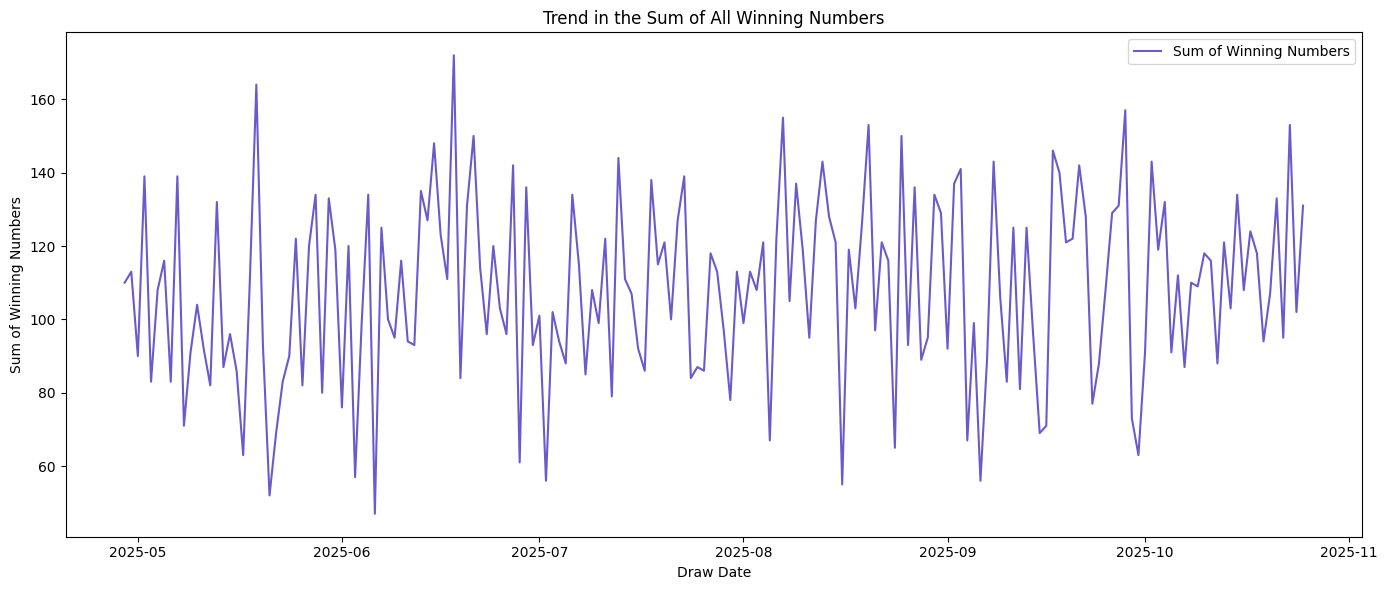

In [64]:

# If you have a date column
plt.figure(figsize=(14, 6))
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    plt.plot(df['Date'], df['sum_win'], label='Sum of Winning Numbers', color='slateblue')
else:
    plt.plot(df.index, df['sum_win'], label='Sum of Winning Numbers', color='slateblue')
plt.xlabel('Draw Date')
plt.ylabel('Sum of Winning Numbers')
plt.title('Trend in the Sum of All Winning Numbers')
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
# Use draw number instead of index for safe calculation
trend_corr = df['sum_win'].corr(pd.Series(range(len(df))))
print(f'Correlation (sum vs. draw order): {trend_corr:.3f}')


Correlation (sum vs. draw order): -0.136


In [66]:
trend_stats = {
    'mean_sum': df['sum_win'].mean(),
    'std_sum': df['sum_win'].std(),
    'min_sum': df['sum_win'].min(),
    'max_sum': df['sum_win'].max(),
    'trend_correlation': trend_corr
}
print(trend_stats)


{'mean_sum': np.float64(108.1), 'std_sum': 25.07421386838117, 'min_sum': 47, 'max_sum': 172, 'trend_correlation': np.float64(-0.13639491514169408)}


In [68]:
# looking for trends or shifts in sums

In [69]:
# add sum column
df['sum_win'] = df[number_columns].sum(axis=1)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

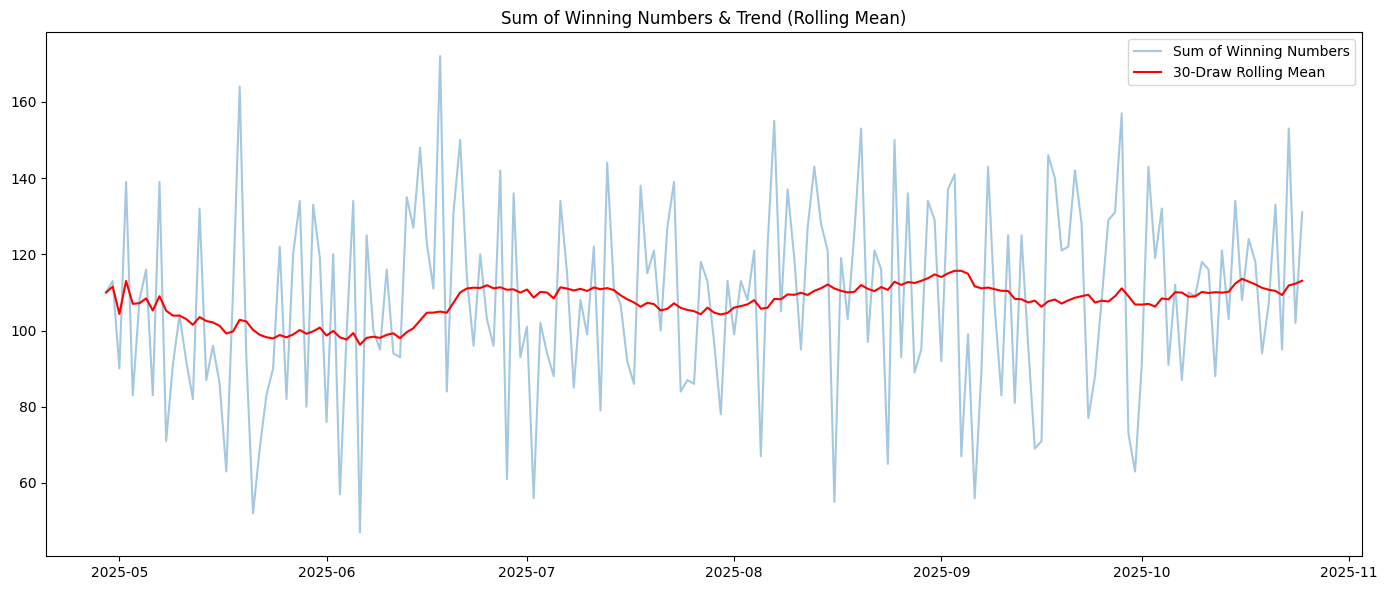

In [70]:
window = 30  # Adjust window size as needed
df['rolling_mean'] = df['sum_win'].rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(14,6))
if 'Date' in df.columns:
    x_vals = df['Date']
else:
    x_vals = df.index
plt.plot(x_vals, df['sum_win'], alpha=0.4, label='Sum of Winning Numbers')
plt.plot(x_vals, df['rolling_mean'], color='red', label=f'{window}-Draw Rolling Mean')
plt.title('Sum of Winning Numbers & Trend (Rolling Mean)')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
x = np.arange(len(df))
y = df['sum_win'].values
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f'Trend: slope={slope:.3f}, p={p_value:.3g}')
if p_value < 0.05:
    print('Significant trend detected.')
    if slope > 0:
        print('Upward trend.')
    else:
        print('Downward trend.')
else:
    print('No significant trend detected.')

Trend: slope=0.066, p=0.0679
No significant trend detected.


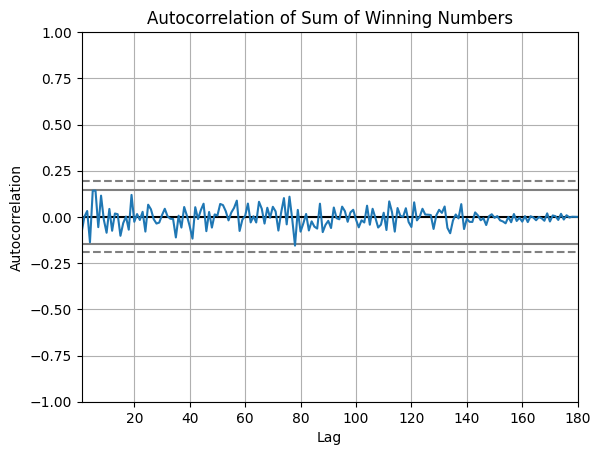

In [74]:
autocorrelation_plot(df['sum_win'])
plt.title('Autocorrelation of Sum of Winning Numbers')
plt.show()

In [80]:
min_sum = df['sum_win'].min()
max_sum = df['sum_win'].max()
mean_sum = df['sum_win'].mean()
print(f"Minimum Sum of wining numbers: {min_sum}")
print(f"max_sum Sum of wining numbers: {max_sum}")
print(f"mean_sum Sum of wining numbers:{mean_sum}")

Minimum Sum of wining numbers: 47
max_sum Sum of wining numbers: 172
mean_sum Sum of wining numbers:108.1


In [88]:
day_to_day_changes = df['sum_win'].diff().dropna()
mean_change = day_to_day_changes.mean()
std_change = day_to_day_changes.std()
print(f" Day to day changes: \n{day_to_day_changes}")
print(f" Mean change: {mean_change}")
print(f" Standard Deviation change: {std_change}")

 Day to day changes: 
178     3.0
177   -23.0
176    49.0
175   -56.0
174    25.0
       ... 
4      26.0
3     -38.0
2      58.0
1     -51.0
0      29.0
Name: sum_win, Length: 179, dtype: float64
 Mean change: 0.11731843575418995
 Standard Deviation change: 36.94959642424911


In [82]:
corr_lag1 = df['sum_win'].autocorr(lag=1)
print(f"Day to day correlation: {corr_lag1}")

Day to day correlation: -0.08224984745136948


In [89]:
# Average range of sums
window = 10
rolling_range = df['sum_win'].rolling(window=window).apply(lambda x: x.max() - x.min(), raw=True)
avg_range = rolling_range.dropna().mean()
print(f'Average range (window={window}): {avg_range:.2f}')


Average range (window=10): 77.16


In [90]:
# Predicted not to win by frequency
freq = all_numbers.value_counts().reindex(range(1, 43), fill_value=0)
not_winning = freq.nsmallest(21).index.tolist()
print("Predicted not to win:", not_winning)


Predicted not to win: [42, 2, 15, 20, 26, 33, 37, 6, 16, 7, 8, 25, 31, 1, 5, 13, 17, 39, 4, 9, 10]


In [94]:
gaps = {}
for num in range(1, 43):
    hits = df[number_columns].apply(lambda row: num in row.values, axis=1)
    hit_indices = np.where(hits)[0]
    if len(hit_indices) > 0:
        gaps[num] = len(df) - 1 - hit_indices[-1]
    else:
        gaps[num] = len(df)
gap_since_last_hit = pd.Series(gaps)


In [95]:
rolling_window = 30
rolling_freq = {}
for num in range(1, 43):
    recent_hits = df[number_columns].tail(rolling_window).apply(lambda row: num in row.values, axis=1)
    rolling_freq[num] = recent_hits.sum()
rolling_freq = pd.Series(rolling_freq)


In [96]:
frequency_norm = (frequency - frequency.min()) / (frequency.max() - frequency.min())
gap_norm = (gap_since_last_hit - gap_since_last_hit.min()) / (gap_since_last_hit.max() - gap_since_last_hit.min())
rolling_norm = (rolling_freq - rolling_freq.min()) / (rolling_freq.max() - rolling_freq.min())


In [97]:
score = (1 - frequency_norm) + gap_norm + (1 - rolling_norm)
ranked = score.sort_values(ascending=False)
print("Predicted not to win:", ranked.head(21).index.tolist())


Predicted not to win: [20, 9, 8, 26, 34, 33, 42, 1, 6, 15, 17, 39, 16, 25, 5, 10, 7, 31, 11, 24, 2]


In [101]:
# total number of combos using half of the available numbers
n = 21  # half the lottery pool
k = 5   # picks per draw

total_combinations = math.comb(n, k)
print(f"Total number of 5-number combinations from 21 numbers: {total_combinations}")


Total number of 5-number combinations from 21 numbers: 20349
